In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import cooler
import bioframe

import cooltools
import cooltools.expected
from cooltools import snipping

import cooltools.lib.plotting
# Set up parallelization
import multiprocess

from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
from scipy import interpolate
from mpl_toolkits.axes_grid import make_axes_locatable
import pyBigWig
import csv

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
from cooltools.insulation import calculate_insulation_score, find_boundaries

import cooltools.eigdecomp
import cooltools.saddle
from scipy.stats import pearsonr
from scipy import linalg
from scipy.signal import argrelextrema
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import itertools
from matplotlib.patches import Rectangle

<ipython-input-1-57267a77b0ab>:21: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


In [44]:
clr_emb_80kb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/DJ73_DJ74_ce10_30_80000_raw.cool")
clr_block_80kb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/DJ70_DJ87_30_80000_raw.cool")


clr_emb_40kb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/DJ73_DJ74_ce10_30_40000_raw.cool")
clr_block_40kb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/DJ70_DJ87_30_40000_raw.cool")

clr_emb_20kb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/DJ73_DJ74_ce10_30_20000_raw.cool")
clr_block_20kb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/DJ70_DJ87_30_20000_raw.cool")

#clr_block_10kb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/DJ87_30_20000_raw.cool")

##### reps

clr_emb_1 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_spreadingrev/DJ73_ce10_30_5000_raw.cool")
clr_emb_2 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_spreadingrev/DJ74_ce10_30_5000_raw.cool")

clr_block_1 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/DJ70_30_5000_raw.cool")
clr_block_2 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/DJ87_30_5000_raw.cool")



In [3]:
bw_ctr = pyBigWig.open("/scratch/kimj50/Jun_ChIP/spreading_revision_v4/block_rescale_bw/JZ1973_JK21_JK16.JZ1973_JK30_JK16.bedgraph_MAPQ20_ratio_rescale_Acenter.bw")
bw_ctr_igg = pyBigWig.open("/scratch/kimj50/Jun_ChIP/spreading_revision_v4/block_rescale_bw/JZ1973_JK21_JK29.JZ1973_JK30_JK29.bedgraph_MAPQ20_ratio_rescale_Acenter.bw")

bw_block = pyBigWig.open("/scratch/kimj50/Jun_ChIP/spreading_revision_v4/block_rescale_bw/JZ2005_JK11_DJ79.JZ2005_JK22_JK36.bedgraph_MAPQ20_ratio_rescale_Acenter.bw")
bw_block_igg = pyBigWig.open("/scratch/kimj50/Jun_ChIP/spreading_revision_v4/block_rescale_bw/JZ2005_JK11_JK33.JZ2005_JK22_JK37.bedgraph_MAPQ20_ratio_rescale_Acenter.bw")


In [70]:
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)
        
def bed3_mids(bed3plus,chrom,start,end):
    a = bed3plus[bed3plus['chrom']==chrom].reset_index()
    mid = (a['start']+a['end'])//2
    b = mid[(mid > start) & (mid < end)]
    return(np.array(b))

def cgi_region(clr,region):
    cg = adaptive_coarsegrain(clr.matrix(balance=True).fetch(region),
                              clr.matrix(balance=False).fetch(region),
                              cutoff=3, max_levels=8)
    cgi = interp_nan(cg)
    return(cgi)

def cgi_all(clr):
    cg = adaptive_coarsegrain(clr.matrix(balance=True)[:],
                              clr.matrix(balance=False)[:],
                              cutoff=3, max_levels=8)
    cgi = interp_nan(cg)
#    cgi = clr.matrix(balance=True)[:]
    return(cgi)

        
def scaling_agg(input_clr,input_regions):
    cvd = cooltools.expected.diagsum(
        clr=input_clr,
        regions=input_regions,
        transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}
    )
    lb_cvd, lb_slopes, lb_distbins = cooltools.expected.logbin_expected(cvd)
    lb_cvd_agg, lb_slopes_agg = cooltools.expected.combine_binned_expected(
        lb_cvd,
        binned_exp_slope=lb_slopes
    )
    lb_cvd_agg['s_bp'] = lb_cvd_agg['diag.avg'] * input_clr.binsize
    lb_slopes_agg['s_bp'] = lb_slopes_agg['diag.avg'] * input_clr.binsize
    x = np.array(lb_slopes_agg['s_bp'])
    y = np.array(lb_slopes_agg['slope'])
    loop_size = x[argrelextrema(y, np.greater)]
    return(lb_cvd_agg,lb_slopes_agg,loop_size)

def a_subt_b_list(list_a,list_b):
    diff = []
    zip_obj = zip(list_a, list_b)
    for list_a_i, list_b_i in zip_obj:
        diff.append(list_a_i-list_b_i)
    return(diff)

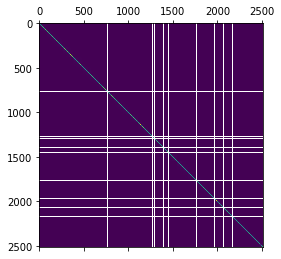

In [10]:
plt.matshow(clr_emb_40kb.matrix(balance=True)[:])

In [4]:

#### chromosome wide ####
ce10=bioframe.read_table('/home/kimj50/ce10.chrom.sizes',schema='bed3')
ce10=bioframe.parse_regions(ce10)


strong = bioframe.read_table("/scratch/kimj50/annotation/sarah_strong.bed",schema='bed').iloc[:,:3]
strong



INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,chrom,start,end
0,X,806476,806877
1,X,1344804,1345205
2,X,1626915,1627316
3,X,2996890,2997291
4,X,4209060,4209461
5,X,5429305,5429706
6,X,6296315,6296716
7,X,8036178,8036579
8,X,9465602,9466003
9,X,11093935,11094336


In [39]:
#### Ps, reps split XA ####
clrs_reps = [clr_emb_1,clr_emb_2,clr_block_1,clr_block_2]

agg_XA_clrs_reps = []
for i in range(len(clrs_reps)):
    agg_XA = []
    a = scaling_agg(clrs_reps[i],ce10.iloc[0:4].reset_index(drop=True))
    x = scaling_agg(clrs_reps[i],ce10.iloc[[5]].reset_index(drop=True))
    agg_XA.append(a)
    agg_XA.append(x)
    agg_XA_clrs_reps.append(agg_XA)

396014.7053732048
198721.1700794477
396015.3178430723
198720.60412037096
396014.567609199
314141.2088003716
396012.8665207851
198723.00837184052


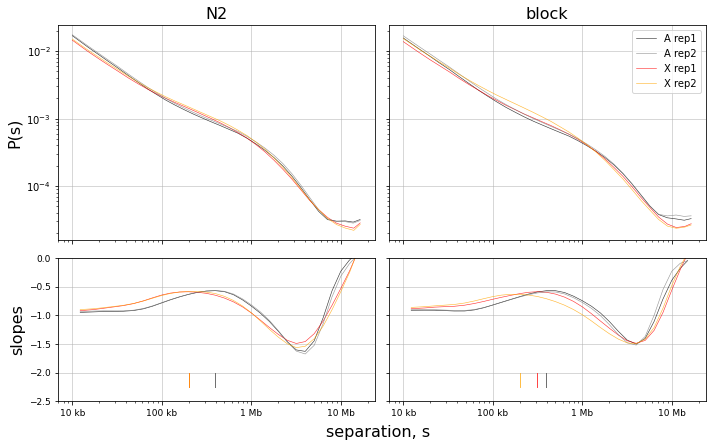

In [40]:
########################## Ps, slopes, split reps ############################
f, axs = plt.subplots(
    figsize=(10,6),
    ncols=2,
    nrows=2,
    sharex=True, sharey='row',
    gridspec_kw={'height_ratios':[6,4]}
)

# sample grouping #
emb_reps = [agg_XA_clrs_reps[0],agg_XA_clrs_reps[1]]
L3_reps = [agg_XA_clrs_reps[2],agg_XA_clrs_reps[3]]

sample_grps = [emb_reps,L3_reps]
# structure: layer1=conditions, layer2=reps, layer3=A,X, layer4=ps,slopes,loopsize #

# global params and labels #
Alpha = 0.8
lineWidth = 0.6
bigFont = 16
smallFont = 9
slopes_minmax = [-2.5,0]
subtitles = ['N2','block']
labels = [['A rep1','X rep1'], ['A rep2', 'X rep2']]
colors = [['black','red'],['grey','orange']]

# plot #
for s in range(len(sample_grps)):
    dat_agg = sample_grps[s]
    ax1 = axs[0,s]
    ax2 = axs[1,s]
    for i in range(len(dat_agg)):
        for j in range(len(dat_agg[i])):
            ax1.loglog(
                dat_agg[i][j][0]['s_bp'],
                dat_agg[i][j][0]['balanced.avg'],
                label=labels[i][j],
                color=colors[i][j],linewidth=lineWidth,alpha=Alpha
            )
            ax2.semilogx(
                dat_agg[i][j][1]['s_bp'],
                dat_agg[i][j][1]['slope'],
                label=labels[i][j],
                color=colors[i][j],linewidth=lineWidth,alpha=Alpha
            )
            loopmin = dat_agg[i][j][2]>50000
            loopmax = dat_agg[i][j][2]<1000000
            loopsize = max(dat_agg[i][j][2][np.logical_and(loopmin,loopmax)])
            print(loopsize)
            ax2.axvline(x=loopsize,ymin=0.1,ymax=0.2,c=colors[i][j],lw=0.9,alpha=Alpha)
            
    ax1.grid(lw=0.5)
    ax2.grid(lw=0.5)
    format_ticks(ax2,y=False,rotate=False)
    ax2.tick_params(labelsize=smallFont)
    ax2.set_ylim(slopes_minmax)
    
    ax1.set_title(subtitles[s],size=bigFont)

# ylabel
axs[0,0].set_ylabel('P(s)',size=bigFont)
axs[1,0].set_ylabel('slopes',size=bigFont)

# big xlabel
f.text(0.53, -0.02, 'separation, s', ha='center',fontsize=bigFont)

#add legend to plot
handles, labels = axs[0,1].get_legend_handles_labels()
order = [0,2,1,3]
axs[0,1].legend([handles[idx] for idx in order],[labels[idx] for idx in order])



plt.tight_layout()

In [13]:
#windows = [60000,80000,160000]

resolution = 20000
windows = [4*resolution, 8*resolution, 16*resolution]
ins_emb = calculate_insulation_score(clr_emb_20kb, windows, verbose=True)
ins_block = calculate_insulation_score(clr_block_20kb, windows, verbose=True)


resolution = 40000
windows = [4*resolution, 8*resolution, 16*resolution]
ins_emb_40kb = calculate_insulation_score(clr_emb_40kb, windows, verbose=True)
ins_block_40kb = calculate_insulation_score(clr_block_40kb, windows, verbose=True)





INFO:root:Processing I
INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:root:Processing II
INFO:root:Processing III
INFO:root:Processing IV
INFO:root:Processing V
INFO:root:Processing X
INFO:root:Processing I
INFO:root:Processing II
INFO:root:Processing III
INFO:root:Processing IV
INFO:root:Processing V
INFO:root:Processing X
INFO:root:Processing I
INFO:root:Processing II
INFO:root:Processing III
INFO:root:Processing IV
INFO:root:Processing V
INFO:root:Processing X
INFO:root:Processing I
INFO:root:Processing II
INFO:root:Processing III
INFO:root:Processing IV
INFO:root:Processing V
INFO:root:Processing X


In [18]:
ins_emb_40kb

,chrom,start,end,is_bad_bin,log2_insulation_score_160000,n_valid_pixels_160000,log2_insulation_score_320000,n_valid_pixels_320000,log2_insulation_score_640000,n_valid_pixels_640000
0,I,0,40000,False,0.819206,2.0,0.897031,6.0,1.107412,14.0
1,I,40000,80000,False,0.657386,5.0,0.869763,13.0,1.101146,29.0
2,I,80000,120000,False,0.515480,9.0,0.845368,21.0,1.084165,45.0
3,I,120000,160000,False,0.389997,13.0,0.750507,29.0,1.035840,61.0
4,I,160000,200000,False,0.430507,13.0,0.672712,37.0,0.987540,77.0
...,...,...,...,...,...,...,...,...,...,...
2504,X,17520000,17560000,False,0.219145,13.0,0.519799,29.0,0.897042,61.0
2505,X,17560000,17600000,False,0.362889,9.0,0.579094,21.0,0.921129,45.0
2506,X,17600000,17640000,False,0.571055,5.0,0.666224,13.0,0.959800,29.0
2507,X,17640000,17680000,False,0.853551,2.0,0.784738,6.0,1.046012,14.0


In [16]:
len(cgi_all(clrs[0]))
len(ins_emb)

2509

In [31]:
xval=np.array(range(len(clr_region)))
xval

array([   0,    1,    2, ..., 2506, 2507, 2508])

/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur


I : (0, 189)
II : (189, 380)
III : (380, 553)
IV : (553, 772)
V : (772, 1034)
X : (1034, 1256)
I : (0, 189)
II : (189, 380)
III : (380, 553)
IV : (553, 772)
V : (772, 1034)
X : (1034, 1256)


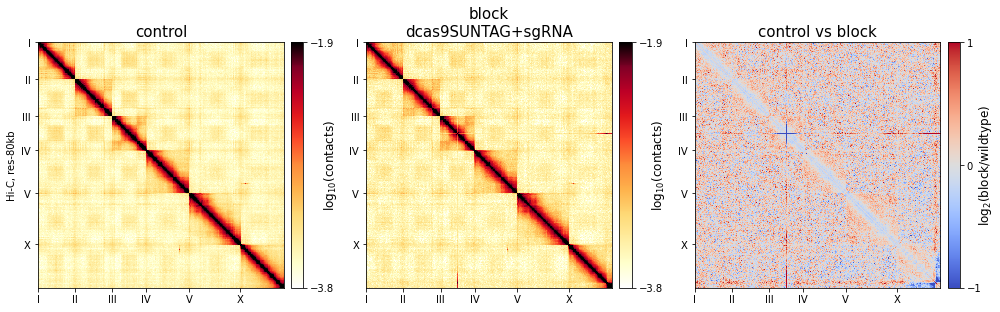

In [75]:
f, axs = plt.subplots(
    figsize=(14, 8),
    nrows=1,
    ncols=3,
    sharex=False,
    sharey=False
)

#### data
clrs = [clr_emb_80kb,clr_block_80kb]

# params
#ins_window = '160000'

sub_titles = ['control','block\ndcas9SUNTAG+sgRNA',"control vs block"]
#row_labels = ['Hi-C, 20-kb','DPY-27 \n(Ercan,2009)']
smallFont = 12
bigFont = 15
minmax_clr = [-3.8,-1.9]

minmax_ratio = [-1,1]


block_site = 7356367
annot = [block_site]

start,end = 0,17718800

region = 'X:'+str(start)+'-'+str(end)

#start,end = 5_000_000,110_500_000
#region = 'X:'+str(start)+'-'+str(end)
extents = (start, end, end, start)

ticks_pixels = [5_000_000,10_000_000,15_000_000]
#ticks_labels = [0,2,4,6]




for i in range(2):
    ax = axs[i]
    clr_region = cgi_all(clrs[i])
    ### to make a list of chromosome start/ends in bins:
    chromstarts = []
    for j in clrs[i].chromnames:
        print(f'{j} : {clrs[i].extent(j)}')
        chromstarts.append(clrs[i].extent(j)[0])
    
    im = ax.matshow(
        np.log10(clr_region),
        cmap='fall',
        vmin=minmax_clr[0],vmax=minmax_clr[1])
    
    ax.set_xticks(chromstarts)
    ax.set_xticklabels(clrs[i].chromnames)
    ax.set_yticks(chromstarts)
    ax.set_yticklabels(clrs[i].chromnames)
    ax.xaxis.tick_bottom()
    ax.set_title(sub_titles[i],fontsize=bigFont)
    divider = make_axes_locatable(ax)
    if i == 0:
        ax.set(ylabel='Hi-C, res-80kb')
#    ax.set(xticks=chromstarts, xticklabels=clrs[i].chromnames,
#       xlabel='position, chrom#', ylabel='position, bin#')
    
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax, ticks=[minmax_clr[0],minmax_clr[1]])
    cbar.ax.set_ylabel('$\log_{10}$(contacts)', rotation=90,fontsize=smallFont,labelpad=-13)
#    ax.set_title(sub_titles[i],fontsize=bigFont)
#    format_ticks(ax,y=False,x=True,rotate=90)
#    ax.tick_params(axis="both", bottom=True, top=True, labelbottom=False, labeltop=True,left=True,labelleft=False)
#    ax.set(xticks=ticks_pixels,yticks=ticks_pixels,yticklabels=[])
    
ax=axs[2]
clr_region1 =  cgi_all(clrs[0])
clr_region2 =  cgi_all(clrs[1])
im = ax.matshow(
    np.log2(clr_region2/clr_region1),
    cmap='coolwarm',
    vmin=minmax_ratio[0],vmax=minmax_ratio[1]
    )

ax.set_title(sub_titles[2],fontsize=bigFont)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax,ticks=[minmax_ratio[0],0,minmax_ratio[1]])
cbar.ax.set_ylabel('$\log_{2}$(block/wildtype)', rotation=90,fontsize=smallFont,labelpad=-5)

ax.set_xticks(chromstarts)
ax.set_xticklabels(clrs[i].chromnames)
ax.set_yticks(chromstarts)
ax.set_yticklabels(clrs[i].chromnames)
ax.xaxis.tick_bottom()

plt.tight_layout()

In [76]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/t.pdf',dpi=800,bbox_inches='tight')

[320000]


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur


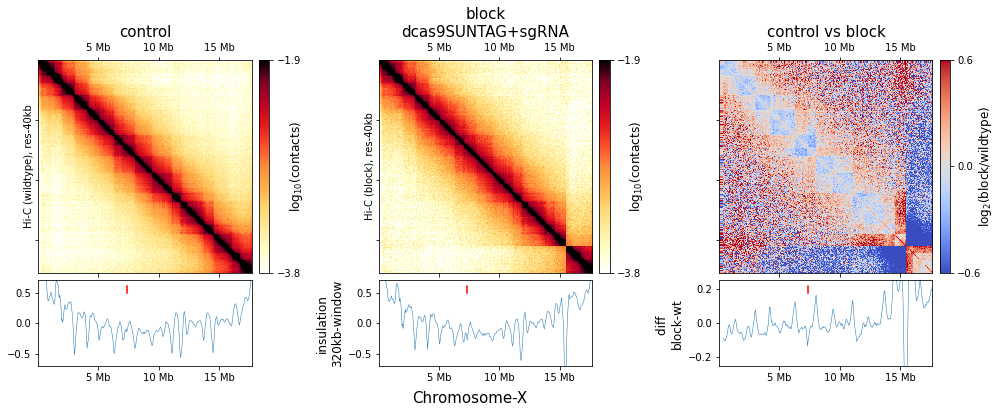

In [48]:
f, axs = plt.subplots(
    figsize=(14, 8),
    nrows=1,
    ncols=3,
    sharex=False,
    sharey=False
)

#### data
clrs = [clr_emb_40kb,clr_block_40kb]
ins = [ins_emb_40kb,ins_block_40kb]
resolution = 40000
windows = [4*resolution, 8*resolution, 16*resolution]
windows = [8*resolution]
print(windows)
# params
#ins_window = '160000'

sub_titles = ['control','block\ndcas9SUNTAG+sgRNA',"control vs block"]
#row_labels = ['Hi-C, 20-kb','DPY-27 \n(Ercan,2009)']
smallFont = 12
bigFont = 15
minmax_clr = [-3.8,-1.9]

minmax_ratio = [-0.6,0.6]
minmax_ins = [-0.7,0.7]

block_site = 7356367
annot = [block_site]

start,end = 0,17718800

region = 'X:'+str(start)+'-'+str(end)

#start,end = 5_000_000,110_500_000
#region = 'X:'+str(start)+'-'+str(end)
extents = (start, end, end, start)

ticks_pixels = [5_000_000,10_000_000,15_000_000]
#ticks_labels = [0,2,4,6]




for i in range(2):
    ax = axs[i]
    clr_region = cgi_region(clrs[i],region)
    im = ax.matshow(
        np.log10(clr_region),
        cmap='fall',
        vmin=minmax_clr[0],vmax=minmax_clr[1],
        extent=extents)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax, ticks=[minmax_clr[0],minmax_clr[1]])
    cbar.ax.set_ylabel('$\log_{10}$(contacts)', rotation=90,fontsize=smallFont,labelpad=-13)
    ax.set_title(sub_titles[i],fontsize=bigFont)
    format_ticks(ax,y=False,x=True,rotate=False)
    ax.tick_params(axis="both", bottom=True, top=True, labelbottom=False, labeltop=True,left=True,labelleft=False)
    ax.set(xticks=ticks_pixels,yticks=ticks_pixels,yticklabels=[])
    if i == 0:
        ax.set_ylabel('')

    
    
    
    ##### insulation ####
    ax1 = divider.append_axes("bottom", size="40%", pad=0.1,sharex=ax)
    ins_region = bioframe.select(ins[i], region)
    xval=np.linspace(start,end, len(clr_region))
    xval=ins_region[['start', 'end']].mean(axis=1)
    for j in range(len(windows)):
        yval=np.array(ins_region['log2_insulation_score_'+str(windows[j])],dtype=float)
        mask = np.isfinite(yval)
        ax1.plot(xval[mask], 
                 yval[mask],lw=0.5)
        ax1.set_xlim([xval.min(),xval.max()])
        ax1.set_ylim([minmax_ins[0],minmax_ins[1]])
    for a in range(len(annot)):
        ax1.axvline(x=annot[a],ymin=0.85,ymax=0.93,c="red",alpha=1)
    
    format_ticks(ax1,y=False,x=True,rotate=False)
    ax1.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    ax1.set(xticks=ticks_pixels)
    if i == 0:
        ax.set(ylabel='Hi-C (wildtype), res-40kb')
    if i == 1:
        ax.set(ylabel='Hi-C (block), res-40kb')

        ax1.set(ylabel='insulation\n320kb-window')
        ax1.yaxis.label.set_size(smallFont)
        

ax=axs[2]
clr_region1 = cgi_region(clrs[0],region)
clr_region2 = cgi_region(clrs[1],region)
im = ax.matshow(
    np.log2(clr_region2/clr_region1),
    cmap='coolwarm',
    extent=extents,
    vmin=minmax_ratio[0],vmax=minmax_ratio[1]
    )

ax.set_title(sub_titles[2],fontsize=bigFont)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax,ticks=[minmax_ratio[0],0,minmax_ratio[1]])
cbar.ax.set_ylabel('$\log_{2}$(block/wildtype)', rotation=90,fontsize=smallFont,labelpad=-5)


format_ticks(ax,y=False,x=True,rotate=False)
ax.tick_params(axis="both", bottom=True, top=True, labelbottom=False, labeltop=True,left=True,labelleft=False)
ax.set(xticks=ticks_pixels,yticks=ticks_pixels,yticklabels=[])

################## ins diff ########################
ax1 = divider.append_axes("bottom", size="40%", pad=0.1,sharex=ax)
ins1 = bioframe.select(ins[0], region)
ins2 = bioframe.select(ins[1], region)
for j in range(len(windows)):
    ins_diff = a_subt_b_list(ins2['log2_insulation_score_'+str(windows[j])],ins1['log2_insulation_score_'+str(windows[j])])
    xval=ins1[['start', 'end']].mean(axis=1)
    yval=np.array(ins_diff,dtype=float)
    mask = np.isfinite(yval)
    ax1.plot(xval[mask], 
             yval[mask],lw=0.5)
ax1.set_xlim([xval.min(),xval.max()])
ax1.set_ylim(-0.25,0.25)
for a in range(len(annot)):
    ax1.axvline(x=annot[a],ymin=0.85,ymax=0.93,c="red",alpha=1)

format_ticks(ax1,y=False,x=True,rotate=False)
ax1.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
ax1.set(xticks=ticks_pixels)
ax1.set(ylabel='diff \nblock-wt')
ax1.yaxis.label.set_size(smallFont)

f.text(0.47, 0.17, 'Chromosome-X', ha='center',fontsize=bigFont)

plt.tight_layout()

In [49]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/FigX_block_40kb_chromosomewide.pdf',dpi=800,bbox_inches='tight')

[320000]


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur


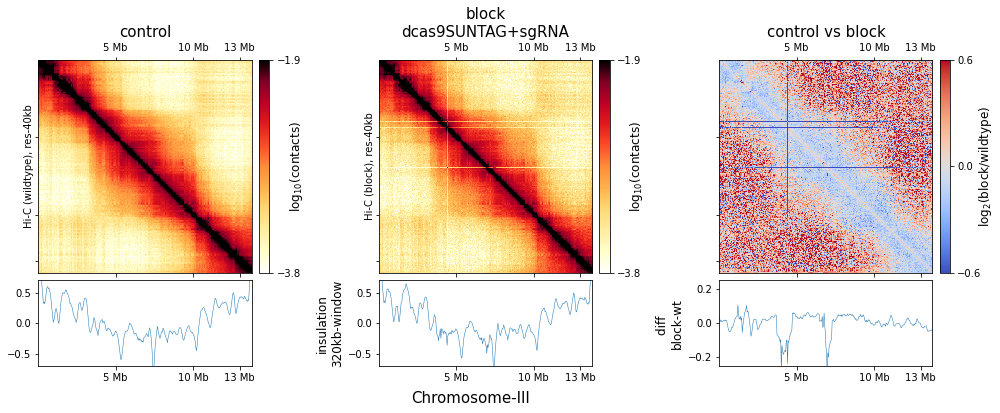

In [59]:
f, axs = plt.subplots(
    figsize=(14, 8),
    nrows=1,
    ncols=3,
    sharex=False,
    sharey=False
)

#### data
clrs = [clr_emb_40kb,clr_block_40kb]
ins = [ins_emb_40kb,ins_block_40kb]
resolution = 40000
windows = [4*resolution, 8*resolution, 16*resolution]
windows = [8*resolution]
print(windows)
# params
#ins_window = '160000'

sub_titles = ['control','block\ndcas9SUNTAG+sgRNA',"control vs block"]
#row_labels = ['Hi-C, 20-kb','DPY-27 \n(Ercan,2009)']
smallFont = 12
bigFont = 15
minmax_clr = [-3.8,-1.9]

minmax_ratio = [-0.6,0.6]
minmax_ins = [-0.7,0.7]

block_site = 7356367
annot = [block_site]

start,end = 0,13783700

region = 'III:'+str(start)+'-'+str(end)

#start,end = 5_000_000,110_500_000
#region = 'X:'+str(start)+'-'+str(end)
extents = (start, end, end, start)

ticks_pixels = [5_000_000,10_000_000,13_000_000]
#ticks_labels = [0,2,4,6]




for i in range(2):
    ax = axs[i]
    clr_region = cgi_region(clrs[i],region)
    im = ax.matshow(
        np.log10(clr_region),
        cmap='fall',
        vmin=minmax_clr[0],vmax=minmax_clr[1],
        extent=extents)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax, ticks=[minmax_clr[0],minmax_clr[1]])
    cbar.ax.set_ylabel('$\log_{10}$(contacts)', rotation=90,fontsize=smallFont,labelpad=-13)
    ax.set_title(sub_titles[i],fontsize=bigFont)
    format_ticks(ax,y=False,x=True,rotate=False)
    ax.tick_params(axis="both", bottom=True, top=True, labelbottom=False, labeltop=True,left=True,labelleft=False)
    ax.set(xticks=ticks_pixels,yticks=ticks_pixels,yticklabels=[])
    if i == 0:
        ax.set_ylabel('')

    
    
    
    ##### insulation ####
    ax1 = divider.append_axes("bottom", size="40%", pad=0.1,sharex=ax)
    ins_region = bioframe.select(ins[i], region)
    xval=ins_region[['start', 'end']].mean(axis=1)
    for j in range(len(windows)):
        yval=np.array(ins_region['log2_insulation_score_'+str(windows[j])],dtype=float)
        mask = np.isfinite(yval)
        ax1.plot(xval[mask], 
                 yval[mask],lw=0.5)
        ax1.set_xlim([xval.min(),xval.max()])
        ax1.set_ylim([minmax_ins[0],minmax_ins[1]])

    format_ticks(ax1,y=False,x=True,rotate=False)
    ax1.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    ax1.set(xticks=ticks_pixels)
    if i == 0:
        ax.set(ylabel='Hi-C (wildtype), res-40kb')
    if i == 1:
        ax.set(ylabel='Hi-C (block), res-40kb')

        ax1.set(ylabel='insulation\n320kb-window')
        ax1.yaxis.label.set_size(smallFont)
        

ax=axs[2]
clr_region1 = cgi_region(clrs[0],region)
clr_region2 = cgi_region(clrs[1],region)
im = ax.matshow(
    np.log2(clr_region2/clr_region1),
    cmap='coolwarm',
    extent=extents,
    vmin=minmax_ratio[0],vmax=minmax_ratio[1]
    )

ax.set_title(sub_titles[2],fontsize=bigFont)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax,ticks=[minmax_ratio[0],0,minmax_ratio[1]])
cbar.ax.set_ylabel('$\log_{2}$(block/wildtype)', rotation=90,fontsize=smallFont,labelpad=-5)


format_ticks(ax,y=False,x=True,rotate=False)
ax.tick_params(axis="both", bottom=True, top=True, labelbottom=False, labeltop=True,left=True,labelleft=False)
ax.set(xticks=ticks_pixels,yticks=ticks_pixels,yticklabels=[])

################## ins diff ########################
ax1 = divider.append_axes("bottom", size="40%", pad=0.1,sharex=ax)
ins1 = bioframe.select(ins[0], region)
ins2 = bioframe.select(ins[1], region)
for j in range(len(windows)):
    ins_diff = a_subt_b_list(ins2['log2_insulation_score_'+str(windows[j])],ins1['log2_insulation_score_'+str(windows[j])])
    xval=ins1[['start', 'end']].mean(axis=1)
    yval=np.array(ins_diff,dtype=float)
    mask = np.isfinite(yval)
    ax1.plot(xval[mask], 
             yval[mask],lw=0.5)
ax1.set_xlim([xval.min(),xval.max()])
ax1.set_ylim(-0.25,0.25)

format_ticks(ax1,y=False,x=True,rotate=False)
ax1.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
ax1.set(xticks=ticks_pixels)
ax1.set(ylabel='diff \nblock-wt')
ax1.yaxis.label.set_size(smallFont)

f.text(0.47, 0.17, 'Chromosome-III', ha='center',fontsize=bigFont)

plt.tight_layout()

In [57]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/FigX_block_40kb_chromosomewide_chrI.pdf',dpi=800,bbox_inches='tight')

[160000]


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur


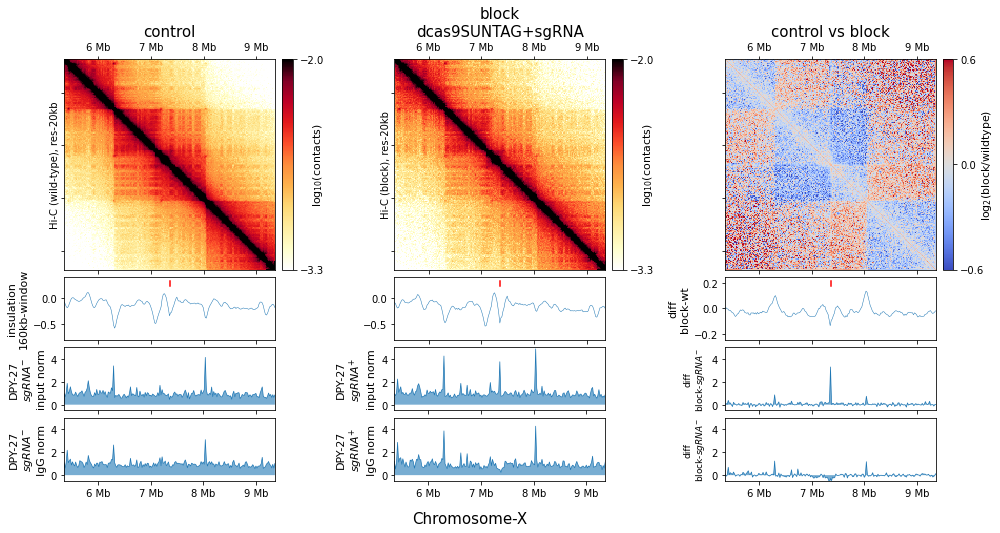

In [44]:
f, axs = plt.subplots(
    figsize=(14, 8),
    nrows=1,
    ncols=3,
    sharex=False,
    sharey=False
)

#### data
clrs = [clr_emb_20kb,clr_block_20kb]
ins = [ins_emb,ins_block]
resolution = 20000
windows = [8*resolution]
print(windows)

sub_titles = ['control','block\ndcas9SUNTAG+sgRNA',"control vs block"]
#row_labels = ['Hi-C, 20-kb','DPY-27 \n(Ercan,2009)']
smallFont = 11
bigFont = 15
minmax_clr = [-3.3,-2]

minmax_ratio = [-0.6,0.6]
minmax_ins = [-0.8,0.4]

block_site = 7356367
annot = [block_site]
up = 2_000_000
down = 2_000_000
start,end = block_site-up, block_site+down
region = 'X:'+str(start)+'-'+str(end)

#start,end = 5_000_000,110_500_000
#region = 'X:'+str(start)+'-'+str(end)
extents = (start, end, end, start)

ticks_pixels = [6_000_000,7_000_000,8_000_000,9_000_000]
#ticks_labels = [0,2,4,6]

bws = [bw_ctr,bw_block]
bws1 = [bw_ctr_igg,bw_block_igg]
minmax_bw = [-0.5,5]

for i in range(2):
    ax = axs[i]
    clr_region = cgi_region(clrs[i],region)
    im = ax.matshow(
        np.log10(clr_region),
        cmap='fall',
        vmin=minmax_clr[0],vmax=minmax_clr[1],
        extent=extents)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax, ticks=[minmax_clr[0],minmax_clr[1]])
    cbar.ax.set_ylabel('$\log_{10}$(contacts)', rotation=90,fontsize=smallFont,labelpad=-13)
    ax.set_title(sub_titles[i],fontsize=bigFont)
    format_ticks(ax,y=False,x=True,rotate=False)
    ax.tick_params(axis="both", bottom=True, top=True, labelbottom=False, labeltop=True,left=True,labelleft=False)
    ax.set(xticks=ticks_pixels,yticks=ticks_pixels,yticklabels=[])
    if i == 0:
        ax.set_ylabel('')

    
    
    
    ##### insulation ####
    ax1 = divider.append_axes("bottom", size="30%", pad=0.1,sharex=ax)
    ins_region = bioframe.select(ins[i], region)
    xval=ins_region[['start', 'end']].mean(axis=1)
    for j in range(len(windows)):
        yval=np.array(ins_region['log2_insulation_score_'+str(windows[j])],dtype=float)
        mask = np.isfinite(yval)
        ax1.plot(xval[mask], 
                 yval[mask],lw=0.5)
        ax1.set_xlim([xval.min(),xval.max()])
        ax1.set_ylim([minmax_ins[0],minmax_ins[1]])
    for a in range(len(annot)):
        ax1.axvline(x=annot[a],ymin=0.85,ymax=0.93,c="red",alpha=1)
    
    format_ticks(ax1,y=False,x=True,rotate=False)
    ax1.tick_params(axis="x", bottom=True, top=False, labelbottom=False, labeltop=False)
    ax1.set(xticks=ticks_pixels)
    if i == 0:
        ax.set(ylabel='Hi-C (wild-type), res-20kb')
        ax1.set(ylabel='insulation\n160kb-window')
        ax1.yaxis.label.set_size(smallFont)
    if i == 1:
        ax.set(ylabel='Hi-C (block), res-20kb')
        ax1.yaxis.label.set_size(smallFont)

    
    ##### DPY27 ######

    ax2 = divider.append_axes("bottom", size="30%", pad=0.1)
    bw_region = bws[i].stats('chrX',start,end,type="mean",nBins=len(clr_region))
    xval = np.linspace(start, end, len(clr_region))
    yval = np.array(bw_region, dtype=float)
    mask = np.isfinite(yval)
    ax2.plot(
        xval[mask],
        yval[mask],lw=0.7)
    plt.fill_between(xval[mask],0,yval[mask],interpolate=False,alpha=0.6)
    ax2.set_ylim([minmax_bw[0],minmax_bw[1]])
    ax2.set_xlim(xval.min(),xval.max())
    if i == 0 :
        ax2.set(ylabel='DPY-27\n$sgRNA^{-}$\ninput norm')
    if i == 1:
        ax2.set(ylabel='DPY-27\n$sgRNA^{+}$\ninput norm')
    ax2.yaxis.label.set_size(smallFont)
    ax2.set(xticks=ticks_pixels)
    format_ticks(ax2,y=False,x=True,rotate=False)
    ax2.tick_params(axis="x", bottom=True, top=False, labelbottom=False, labeltop=False)
    ax2.set(xticks=ticks_pixels)


    ax2 = divider.append_axes("bottom", size="30%", pad=0.1)
    bw_region = bws1[i].stats('chrX',start,end,type="mean",nBins=len(clr_region))
    xval = np.linspace(start, end, len(clr_region))
    yval = np.array(bw_region, dtype=float)
    mask = np.isfinite(yval)
    ax2.plot(
        xval[mask],
        yval[mask],lw=0.7)
    plt.fill_between(xval[mask],0,yval[mask],interpolate=False,alpha=0.6)
    ax2.set_ylim([minmax_bw[0],minmax_bw[1]])
    ax2.set_xlim(xval.min(),xval.max())
    if i == 0 :
        ax2.set(ylabel='DPY-27\n$sgRNA^{-}$\nIgG norm')
    if i == 1:
        ax2.set(ylabel='DPY-27\n$sgRNA^{+}$\nIgG norm')

    ax2.yaxis.label.set_size(smallFont)
    ax2.set(xticks=ticks_pixels)
    format_ticks(ax2,y=False,x=True,rotate=False)
    ax2.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    ax2.set(xticks=ticks_pixels)

    
    
ax=axs[2]
clr_region1 = cgi_region(clrs[0],region)
clr_region2 = cgi_region(clrs[1],region)
im = ax.matshow(
    np.log2(clr_region2/clr_region1),
    cmap='coolwarm',
    extent=extents,
    vmin=minmax_ratio[0],vmax=minmax_ratio[1]
    )

ax.set_title(sub_titles[2],fontsize=bigFont)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax,ticks=[minmax_ratio[0],0,minmax_ratio[1]])
cbar.ax.set_ylabel('$\log_{2}$(block/wildtype)', rotation=90,fontsize=smallFont,labelpad=-5)


format_ticks(ax,y=False,x=True,rotate=False)
ax.tick_params(axis="both", bottom=True, top=True, labelbottom=False, labeltop=True,left=True,labelleft=False)
ax.set(xticks=ticks_pixels,yticks=ticks_pixels,yticklabels=[])

################## ins diff ########################
ax1 = divider.append_axes("bottom", size="30%", pad=0.1,sharex=ax)
ins1 = bioframe.select(ins[0], region)
ins2 = bioframe.select(ins[1], region)
for j in range(len(windows)):
    ins_diff = a_subt_b_list(ins2['log2_insulation_score_'+str(windows[j])],ins1['log2_insulation_score_'+str(windows[j])])
    xval=ins1[['start', 'end']].mean(axis=1)
    yval=np.array(ins_diff,dtype=float)
    mask = np.isfinite(yval)
    ax1.plot(xval[mask], 
             yval[mask],lw=0.5)
ax1.set_xlim([xval.min(),xval.max()])
ax1.set_ylim(-0.25,0.25)
for a in range(len(annot)):
    ax1.axvline(x=annot[a],ymin=0.85,ymax=0.93,c="red",alpha=1)

format_ticks(ax1,y=False,x=True,rotate=False)
ax1.tick_params(axis="x", bottom=True, top=False, labelbottom=False, labeltop=False)
ax1.set(xticks=ticks_pixels)
ax1.set(ylabel='diff\nblock-wt')
ax1.yaxis.label.set_size(smallFont)

################## chip diff ########################
ax2 = divider.append_axes("bottom", size="30%", pad=0.1,sharex=ax)
bw1 = bws[0].stats('chrX',start,end,type="mean",nBins=len(clr_region1))
bw2 = bws[1].stats('chrX',start,end,type="mean",nBins=len(clr_region2))
bw_diff = np.subtract(np.array(bw2,dtype=float),np.array(bw1,dtype=float))
xval=np.linspace(start, end, len(clr_region1))
yval=np.array(bw_diff,dtype=float)
mask = np.isfinite(yval)
ax2.plot(
    xval[mask],
    yval[mask],lw=0.7)
plt.fill_between(xval[mask],0,yval[mask],interpolate=False,alpha=0.6)
ax2.set_ylim([minmax_bw[0],minmax_bw[1]])

ax2.tick_params(axis="x", bottom=True, top=False, labelbottom=False, labeltop=False)
ax2.set(xticks=ticks_pixels)
ax2.set(ylabel='diff\nblock-$sgRNA^{-}$')
ax2.yaxis.label.set_size(9)



ax2 = divider.append_axes("bottom", size="30%", pad=0.1,sharex=ax)
bw1 = bws1[0].stats('chrX',start,end,type="mean",nBins=len(clr_region1))
bw2 = bws1[1].stats('chrX',start,end,type="mean",nBins=len(clr_region2))
bw_diff = np.subtract(np.array(bw2,dtype=float),np.array(bw1,dtype=float))
xval=np.linspace(start, end, len(clr_region1))
yval=np.array(bw_diff,dtype=float)
mask = np.isfinite(yval)
ax2.plot(
    xval[mask],
    yval[mask],lw=0.7)
plt.fill_between(xval[mask],0,yval[mask],interpolate=False,alpha=0.6)
ax2.set_ylim([minmax_bw[0],minmax_bw[1]])

ax2.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
ax2.set(xticks=ticks_pixels)
ax2.set(ylabel='diff\nblock-$sgRNA^{-}$')
ax2.yaxis.label.set_size(9)



f.text(0.47, 0.03, 'Chromosome-X', ha='center',fontsize=bigFont)



plt.tight_layout()

In [45]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/FigX_block_20kb_4MB.pdf',dpi=800,bbox_inches='tight')

In [41]:
#### chromosome wide ####
ce10=bioframe.read_table('/home/kimj50/ce10.chrom.sizes',schema='bed3')
ce10=bioframe.parse_regions(ce10)


strong = bioframe.read_table("/scratch/kimj50/annotation/sarah_strong.bed",schema='bed').iloc[:,:3]


block_region = ['X',7351418,7361316]

d = {'chrom': ['X']*3, 
     'start': [7356367-20000, 7356367,7356367+20000],
     'end': [7356368-20000, 7356368,7356368+20000]}
block_bins = pd.DataFrame(d)
#strong_block = pd.concat(strong,block_region)
#strong_block
block_bins
strong['annot'] = 'strong rex'
block_bins['annot'] = ['block-1bin','block','block+1bin']

strong_block = strong.append(block_bins,ignore_index=True)
#pd.concat(strong,block_bins)
#strong_block
#bioframe.overlap(ins_emb,strong_block,how='right')
#ins_emb.iloc[np.where([True,True,False])[0],:]
strong_block

,chrom,start,end,annot
0,X,806476,806877,strong rex
1,X,1344804,1345205,strong rex
2,X,1626915,1627316,strong rex
3,X,2996890,2997291,strong rex
4,X,4209060,4209461,strong rex
5,X,5429305,5429706,strong rex
6,X,6296315,6296716,strong rex
7,X,8036178,8036579,strong rex
8,X,9465602,9466003,strong rex
9,X,11093935,11094336,strong rex


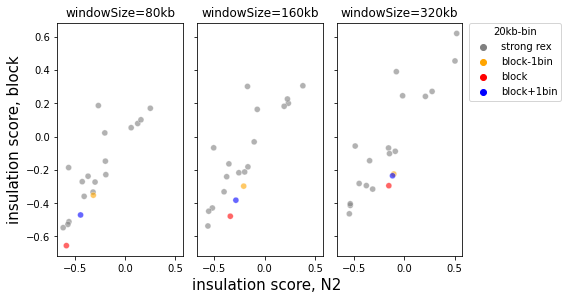

In [44]:
resolution = 20000
windows = [4*resolution, 8*resolution, 16*resolution]
t1 = bioframe.overlap(ins_emb,strong_block,how='right')
t2 = bioframe.overlap(ins_block,strong_block,how='right')

#colors = ['black']*16+
#t2.drop(7)
#t2_1 = t2[np.invert(np.array(t2['is_bad_bin_1'],dtype='bool'))]
#t1
#strong_block['start']
#strong['start']
colors = ['black']*7+['red']*3+['black']*10
#print(t1)
bigFont = 15
#len(t1.drop(7))
f, axs = plt.subplots(
    figsize=(8, 4),
    nrows=1,
    ncols=3,
    sharex=True,
    sharey=True
)
colors = ['grey','orange','red','blue']
for i in range(len(windows)):
    tmp_d = {'N2': t1['log2_insulation_score_'+str(windows[i])+'_1'],
             'block':t2['log2_insulation_score_'+str(windows[i])+'_1'],'labels':t1['annot_2']}
    d = pd.DataFrame(tmp_d)
    a = sns.scatterplot(ax=axs[i],data=d,x='N2',y='block',hue='labels',palette=colors,alpha=0.6)
    a.get_legend().remove()
    a.set_title('windowSize='+str(windows[i]//1000)+'kb')
    a.set_xlabel('')
    if i == 0:
        a.set_ylabel("insulation score, block" ,rotation=90,fontsize=bigFont,labelpad=4)
a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title='20kb-bin')

f.text(0.47, -0.02, 'insulation score, N2', ha='center',fontsize=bigFont)


plt.tight_layout()
#t1

In [45]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/FigX_block_insulationDots.pdf',dpi=800,bbox_inches='tight')

In [58]:
################################## +/-dpy27 test
clr_notag_40kb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK07_JK08_30_40000_raw.cool")
clr_dpy27_40kb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK11_JK12_combined_30_40000_raw.cool")

clr_notag_20kb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK07_JK08_30_20000_raw.cool")
clr_dpy27_20kb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK11_JK12_combined_30_20000_raw.cool")




In [59]:
resolution = 20000
windows = [4*resolution, 8*resolution, 16*resolution]
ins_notag_20kb = calculate_insulation_score(clr_notag_20kb, windows, verbose=True)
ins_dpy27_20kb = calculate_insulation_score(clr_dpy27_20kb, windows, verbose=True)

resolution = 40000
windows = [4*resolution, 8*resolution, 16*resolution]
ins_notag_40kb = calculate_insulation_score(clr_notag_40kb, windows, verbose=True)
ins_dpy27_40kb = calculate_insulation_score(clr_dpy27_40kb, windows, verbose=True)



INFO:root:Processing I
INFO:root:Processing II
INFO:root:Processing III
INFO:root:Processing IV
INFO:root:Processing V
INFO:root:Processing X
INFO:root:Processing I
INFO:root:Processing II
INFO:root:Processing III
INFO:root:Processing IV
INFO:root:Processing V
INFO:root:Processing X
INFO:root:Processing I
INFO:root:Processing II
INFO:root:Processing III
INFO:root:Processing IV
INFO:root:Processing V
INFO:root:Processing X
INFO:root:Processing I
INFO:root:Processing II
INFO:root:Processing III
INFO:root:Processing IV
INFO:root:Processing V
INFO:root:Processing X


[320000]


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur


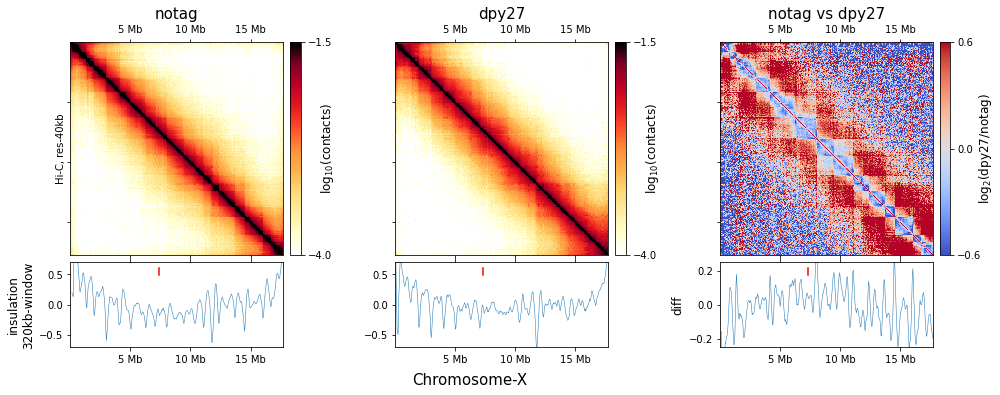

In [61]:
f, axs = plt.subplots(
    figsize=(14, 8),
    nrows=1,
    ncols=3,
    sharex=False,
    sharey=False
)

#### data
clrs = [clr_notag_40kb,clr_dpy27_40kb]
ins = [ins_notag_40kb,ins_dpy27_40kb]
resolution = 40000
windows = [4*resolution, 8*resolution, 16*resolution]
windows = [8*resolution]
print(windows)
# params
#ins_window = '160000'

sub_titles = ['notag','dpy27',"notag vs dpy27"]
#row_labels = ['Hi-C, 20-kb','DPY-27 \n(Ercan,2009)']
smallFont = 12
bigFont = 15
minmax_clr = [-4,-1.5]

minmax_ratio = [-0.6,0.6]
minmax_ins = [-0.7,0.7]

block_site = 7356367
annot = [block_site]

start,end = 0,17718800

region = 'X:'+str(start)+'-'+str(end)

#start,end = 5_000_000,110_500_000
#region = 'X:'+str(start)+'-'+str(end)
extents = (start, end, end, start)

ticks_pixels = [5_000_000,10_000_000,15_000_000]
#ticks_labels = [0,2,4,6]




for i in range(2):
    ax = axs[i]
    clr_region = cgi_region(clrs[i],region)
    im = ax.matshow(
        np.log10(clr_region),
        cmap='fall',
        vmin=minmax_clr[0],vmax=minmax_clr[1],
        extent=extents)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax, ticks=[minmax_clr[0],minmax_clr[1]])
    cbar.ax.set_ylabel('$\log_{10}$(contacts)', rotation=90,fontsize=smallFont,labelpad=-13)
    ax.set_title(sub_titles[i],fontsize=bigFont)
    format_ticks(ax,y=False,x=True,rotate=False)
    ax.tick_params(axis="both", bottom=True, top=True, labelbottom=False, labeltop=True,left=True,labelleft=False)
    ax.set(xticks=ticks_pixels,yticks=ticks_pixels,yticklabels=[])
    if i == 0:
        ax.set_ylabel('')

    
    
    
    ##### insulation ####
    ax1 = divider.append_axes("bottom", size="40%", pad=0.1,sharex=ax)
    ins_region = bioframe.select(ins[i], region)
    xval=ins_region[['start', 'end']].mean(axis=1)
    for j in range(len(windows)):
        yval=np.array(ins_region['log2_insulation_score_'+str(windows[j])],dtype=float)
        mask = np.isfinite(yval)
        ax1.plot(xval[mask], 
                 yval[mask],lw=0.5)
        ax1.set_xlim([xval.min(),xval.max()])
        ax1.set_ylim([minmax_ins[0],minmax_ins[1]])
    for a in range(len(annot)):
        ax1.axvline(x=annot[a],ymin=0.85,ymax=0.93,c="red",alpha=1)
    
    format_ticks(ax1,y=False,x=True,rotate=False)
    ax1.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=False)
    ax1.set(xticks=ticks_pixels)
    if i == 0:
        ax.set(ylabel='Hi-C, res-40kb')
        ax1.set(ylabel='insulation\n320kb-window')
        ax1.yaxis.label.set_size(smallFont)

ax=axs[2]
clr_region1 = cgi_region(clrs[0],region)
clr_region2 = cgi_region(clrs[1],region)
im = ax.matshow(
    np.log2(clr_region2/clr_region1),
    cmap='coolwarm',
    extent=extents,
    vmin=minmax_ratio[0],vmax=minmax_ratio[1]
    )

ax.set_title(sub_titles[2],fontsize=bigFont)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax,ticks=[minmax_ratio[0],0,minmax_ratio[1]])
cbar.ax.set_ylabel('$\log_{2}$(dpy27/notag)', rotation=90,fontsize=smallFont,labelpad=-5)


format_ticks(ax,y=False,x=True,rotate=False)
ax.tick_params(axis="both", bottom=True, top=True, labelbottom=False, labeltop=True,left=True,labelleft=False)
ax.set(xticks=ticks_pixels,yticks=ticks_pixels,yticklabels=[])

################## ins diff ########################
ax1 = divider.append_axes("bottom", size="40%", pad=0.1,sharex=ax)
ins1 = bioframe.select(ins[0], region)
ins2 = bioframe.select(ins[1], region)
for j in range(len(windows)):
    ins_diff = a_subt_b_list(ins2['log2_insulation_score_'+str(windows[j])],ins1['log2_insulation_score_'+str(windows[j])])
    xval=ins1[['start', 'end']].mean(axis=1)
    yval=np.array(ins_diff,dtype=float)
    mask = np.isfinite(yval)
    ax1.plot(xval[mask], 
             yval[mask],lw=0.5)
ax1.set_xlim([xval.min(),xval.max()])
ax1.set_ylim(-0.25,0.25)
for a in range(len(annot)):
    ax1.axvline(x=annot[a],ymin=0.85,ymax=0.93,c="red",alpha=1)

format_ticks(ax1,y=False,x=True,rotate=False)
ax1.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=False)
ax1.set(xticks=ticks_pixels)
ax1.set(ylabel='diff')
ax1.yaxis.label.set_size(smallFont)

f.text(0.47, 0.17, 'Chromosome-X', ha='center',fontsize=bigFont)

plt.tight_layout()

In [62]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/FigX_test_dpy27_40kb_chromosomewide.pdf',dpi=800,bbox_inches='tight')

[160000]


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur


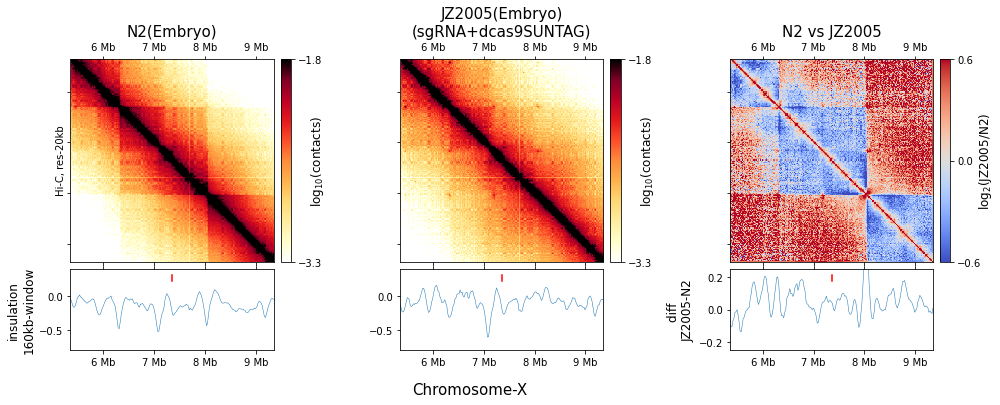

In [56]:
f, axs = plt.subplots(
    figsize=(14, 8),
    nrows=1,
    ncols=3,
    sharex=False,
    sharey=False
)

#### data
clrs = [clr_notag_20kb,clr_dpy27_20kb]
ins = [ins_notag_20kb,ins_dpy27_20kb]
resolution = 20000
windows = [8*resolution]
print(windows)

sub_titles = ['N2(Embryo)','JZ2005(Embryo)\n(sgRNA+dcas9SUNTAG)',"N2 vs JZ2005"]
#row_labels = ['Hi-C, 20-kb','DPY-27 \n(Ercan,2009)']
smallFont = 12
bigFont = 15
minmax_clr = [-3.3,-1.8]

minmax_ratio = [-0.6,0.6]
minmax_ins = [-0.8,0.4]

block_site = 7356367
annot = [block_site]
up = 2_000_000
down = 2_000_000
start,end = block_site-up, block_site+down
region = 'X:'+str(start)+'-'+str(end)

#start,end = 5_000_000,110_500_000
#region = 'X:'+str(start)+'-'+str(end)
extents = (start, end, end, start)

ticks_pixels = [6_000_000,7_000_000,8_000_000,9_000_000]
#ticks_labels = [0,2,4,6]




for i in range(2):
    ax = axs[i]
    clr_region = cgi_region(clrs[i],region)
    im = ax.matshow(
        np.log10(clr_region),
        cmap='fall',
        vmin=minmax_clr[0],vmax=minmax_clr[1],
        extent=extents)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax, ticks=[minmax_clr[0],minmax_clr[1]])
    cbar.ax.set_ylabel('$\log_{10}$(contacts)', rotation=90,fontsize=smallFont,labelpad=-13)
    ax.set_title(sub_titles[i],fontsize=bigFont)
    format_ticks(ax,y=False,x=True,rotate=False)
    ax.tick_params(axis="both", bottom=True, top=True, labelbottom=False, labeltop=True,left=True,labelleft=False)
    ax.set(xticks=ticks_pixels,yticks=ticks_pixels,yticklabels=[])
    if i == 0:
        ax.set_ylabel('')

    
    
    
    ##### insulation ####
    ax1 = divider.append_axes("bottom", size="40%", pad=0.1,sharex=ax)
    ins_region = bioframe.select(ins[i], region)
    xval=ins_region[['start', 'end']].mean(axis=1)
    for j in range(len(windows)):
        yval=np.array(ins_region['log2_insulation_score_'+str(windows[j])],dtype=float)
        mask = np.isfinite(yval)
        ax1.plot(xval[mask], 
                 yval[mask],lw=0.5)
        ax1.set_xlim([xval.min(),xval.max()])
        ax1.set_ylim([minmax_ins[0],minmax_ins[1]])
    for a in range(len(annot)):
        ax1.axvline(x=annot[a],ymin=0.85,ymax=0.93,c="red",alpha=1)
    
    format_ticks(ax1,y=False,x=True,rotate=False)
    ax1.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=False)
    ax1.set(xticks=ticks_pixels)
    if i == 0:
        ax.set(ylabel='Hi-C, res-20kb')
        ax1.set(ylabel='insulation\n160kb-window')
        ax1.yaxis.label.set_size(smallFont)

ax=axs[2]
clr_region1 = cgi_region(clrs[0],region)
clr_region2 = cgi_region(clrs[1],region)
im = ax.matshow(
    np.log2(clr_region2/clr_region1),
    cmap='coolwarm',
    extent=extents,
    vmin=minmax_ratio[0],vmax=minmax_ratio[1]
    )

ax.set_title(sub_titles[2],fontsize=bigFont)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax,ticks=[minmax_ratio[0],0,minmax_ratio[1]])
cbar.ax.set_ylabel('$\log_{2}$(JZ2005/N2)', rotation=90,fontsize=smallFont,labelpad=-5)


format_ticks(ax,y=False,x=True,rotate=False)
ax.tick_params(axis="both", bottom=True, top=True, labelbottom=False, labeltop=True,left=True,labelleft=False)
ax.set(xticks=ticks_pixels,yticks=ticks_pixels,yticklabels=[])

################## ins diff ########################
ax1 = divider.append_axes("bottom", size="40%", pad=0.1,sharex=ax)
ins1 = bioframe.select(ins[0], region)
ins2 = bioframe.select(ins[1], region)
for j in range(len(windows)):
    ins_diff = a_subt_b_list(ins2['log2_insulation_score_'+str(windows[j])],ins1['log2_insulation_score_'+str(windows[j])])
    xval=ins1[['start', 'end']].mean(axis=1)
    yval=np.array(ins_diff,dtype=float)
    mask = np.isfinite(yval)
    ax1.plot(xval[mask], 
             yval[mask],lw=0.5)
ax1.set_xlim([xval.min(),xval.max()])
ax1.set_ylim(-0.25,0.25)
for a in range(len(annot)):
    ax1.axvline(x=annot[a],ymin=0.85,ymax=0.93,c="red",alpha=1)

format_ticks(ax1,y=False,x=True,rotate=False)
ax1.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=False)
ax1.set(xticks=ticks_pixels)
ax1.set(ylabel='diff \nJZ2005-N2')
ax1.yaxis.label.set_size(smallFont)

f.text(0.47, 0.17, 'Chromosome-X', ha='center',fontsize=bigFont)

plt.tight_layout()

In [57]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/FigX_test_dpy27_20kb_4MB.pdf',dpi=800,bbox_inches='tight')